In [1]:
!kaggle datasets download samuelcortinhas/sports-balls-multiclass-image-classification

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification
License(s): CC0-1.0
 99% 399M/401M [00:04<00:00, 135MB/s]
100% 401M/401M [00:04<00:00, 95.4MB/s]


In [2]:
!unzip /content/sports-balls-multiclass-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/cricket_ball/cricket_ball_182.jpg  
  inflating: train/cricket_ball/cricket_ball_183.jpg  
  inflating: train/cricket_ball/cricket_ball_185.jpg  
  inflating: train/cricket_ball/cricket_ball_186.jpg  
  inflating: train/cricket_ball/cricket_ball_187.jpg  
  inflating: train/cricket_ball/cricket_ball_189.jpg  
  inflating: train/cricket_ball/cricket_ball_19.jpg  
  inflating: train/cricket_ball/cricket_ball_190.jpg  
  inflating: train/cricket_ball/cricket_ball_191.jpg  
  inflating: train/cricket_ball/cricket_ball_192.jpg  
  inflating: train/cricket_ball/cricket_ball_195.jpg  
  inflating: train/cricket_ball/cricket_ball_196.jpg  
  inflating: train/cricket_ball/cricket_ball_199.jpg  
  inflating: train/cricket_ball/cricket_ball_200.jpg  
  inflating: train/cricket_ball/cricket_ball_201.jpg  
  inflating: train/cricket_ball/cricket_ball_202.jpg  
  inflating: train/cricket_ball/cricket_ball_209.jpg  
  inflating: tr

In [3]:
import timm
from timm.data import create_dataset
from timm.data.transforms_factory import create_transform

In [4]:
train_dir='/content/train'
test_dir='/content/test'

train_data = create_dataset(name='', root=train_dir, transform=create_transform(224, is_training=True, auto_augment='rand-m9-mstd0.5'))
test_data = create_dataset(name='', root=test_dir, transform=create_transform(224))

In [5]:
from timm.data.loader import create_loader

In [6]:
try:
    # only works if gpu present on machine
    train_dataloader = create_loader(train_data, input_size=224, batch_size=32, is_training=True)
    test_dataloader = create_loader(test_data, input_size=224, batch_size=32, is_training=False)
except:
    train_dataloader = create_loader(train_data, input_size=224, batch_size=32, is_training=True,use_prefetcher=False)
    test_dataloader = create_loader(test_data, input_size=224, batch_size=32, is_training=False,use_prefetcher=False)

In [7]:
import os
class_names = sorted(entry.name for entry in os.scandir(train_dir) if entry.is_dir())
class_names

['american_football',
 'baseball',
 'basketball',
 'billiard_ball',
 'bowling_ball',
 'cricket_ball',
 'football',
 'golf_ball',
 'hockey_ball',
 'hockey_puck',
 'rugby_ball',
 'shuttlecock',
 'table_tennis_ball',
 'tennis_ball',
 'volleyball']

In [8]:
nclasses=len(class_names)
nclasses

15

In [9]:
m = timm.create_model('resnet26d', pretrained=True, exportable=True)

print(f'Original pooling: {m.global_pool}')
print(f'Original classifier: {m.get_classifier()}')

m.reset_classifier(nclasses, 'max')

print(f'Modified pooling: {m.global_pool}')
print(f'Modified classifier: {m.get_classifier()}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

Original pooling: SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
Original classifier: Linear(in_features=2048, out_features=1000, bias=True)
--------------------
Modified pooling: SelectAdaptivePool2d(pool_type=max, flatten=Flatten(start_dim=1, end_dim=-1))
Modified classifier: Linear(in_features=2048, out_features=15, bias=True)


In [10]:
import torch
from torch import nn
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)

In [11]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA GPU
elif torch.backends.mps.is_available():
    device = torch.device('mps') #Apple GPU
else:
    device = torch.device("cpu")

In [13]:
device

device(type='cuda')

In [14]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=m,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1450 | train_acc: 0.4461 | test_loss: 1.2300 | test_acc: 0.6415
Epoch: 2 | train_loss: 1.4757 | train_acc: 0.5682 | test_loss: 1.1523 | test_acc: 0.6514
Epoch: 3 | train_loss: 1.3678 | train_acc: 0.6025 | test_loss: 1.2265 | test_acc: 0.6534
Epoch: 4 | train_loss: 1.2727 | train_acc: 0.6343 | test_loss: 1.0887 | test_acc: 0.7014
Epoch: 5 | train_loss: 1.1435 | train_acc: 0.6609 | test_loss: 0.7426 | test_acc: 0.7874
[INFO] Total training time: 482.897 seconds


In [15]:
import matplotlib.pyplot as plt
# Plot loss curves of a model
def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

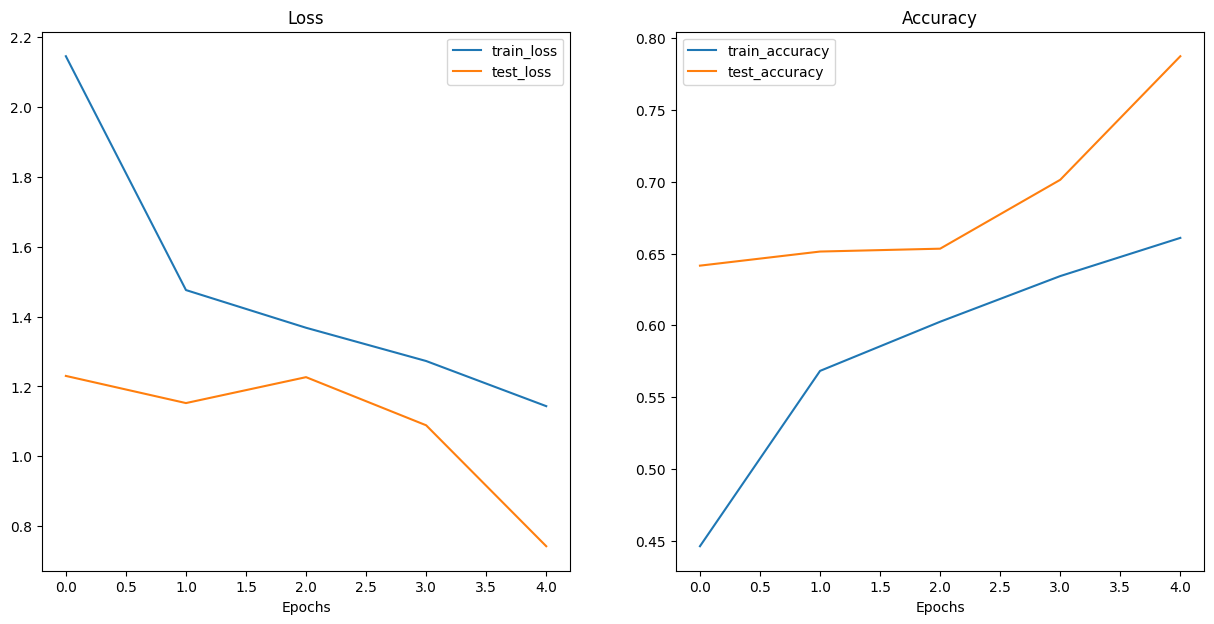

In [16]:
plot_loss_curves(results)

# Model2

In [17]:
m1 = timm.create_model('resnet26d', pretrained=True, exportable=True)

print(f'Original pooling: {m1.global_pool}')
print(f'Original classifier: {m1.get_classifier()}')
print('--------------------')

m1.reset_classifier(nclasses, 'avg')

print(f'Modified pooling: {m1.global_pool}')
print(f'Modified classifier: {m1.get_classifier()}')

Original pooling: SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
Original classifier: Linear(in_features=2048, out_features=1000, bias=True)
--------------------
Modified pooling: SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
Modified classifier: Linear(in_features=2048, out_features=15, bias=True)


In [18]:
import torch
from torch import nn
from timm.optim import create_optimizer_v2
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = create_optimizer_v2(m1, opt='sgd', lr=0.01, momentum=0.8); optimizer, type(optimizer)

(SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0.8
     nesterov: True
     weight_decay: 0.0
 ),
 torch.optim.sgd.SGD)

In [19]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results2 = train(model=m1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1269 | train_acc: 0.6618 | test_loss: 0.7016 | test_acc: 0.7880
Epoch: 2 | train_loss: 0.7605 | train_acc: 0.7662 | test_loss: 0.5683 | test_acc: 0.8341
Epoch: 3 | train_loss: 0.6390 | train_acc: 0.8025 | test_loss: 0.4698 | test_acc: 0.8712
Epoch: 4 | train_loss: 0.5616 | train_acc: 0.8291 | test_loss: 0.4287 | test_acc: 0.8794
Epoch: 5 | train_loss: 0.4836 | train_acc: 0.8529 | test_loss: 0.4711 | test_acc: 0.8658
[INFO] Total training time: 474.076 seconds


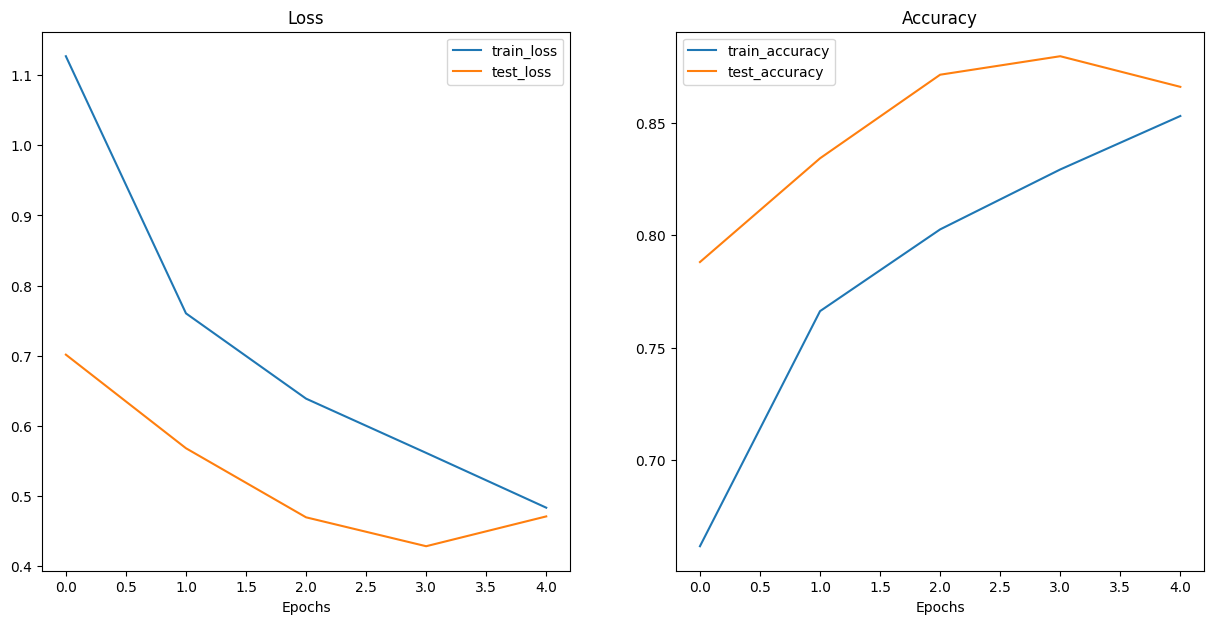

In [20]:
plot_loss_curves(results2)

In [21]:
from typing import List, Tuple
import torchvision
from torchvision import transforms
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)

    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

In [22]:
import random
from pathlib import Path
num_images_to_plot = 3
test_dir = "/content/test"
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data

In [23]:
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

In [24]:
test_image_path_sample

[PosixPath('/content/test/table_tennis_ball/table_tennis_ball_1006.jpg'),
 PosixPath('/content/test/tennis_ball/tennis_814.jpg'),
 PosixPath('/content/test/football/football_912.jpg')]

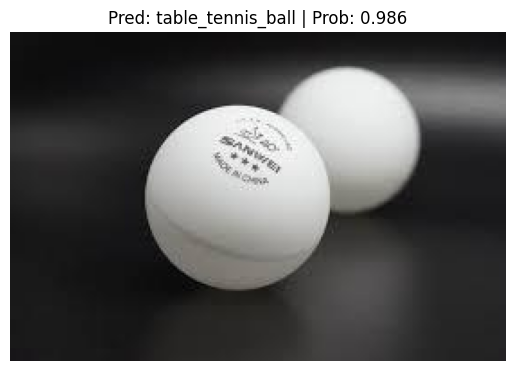

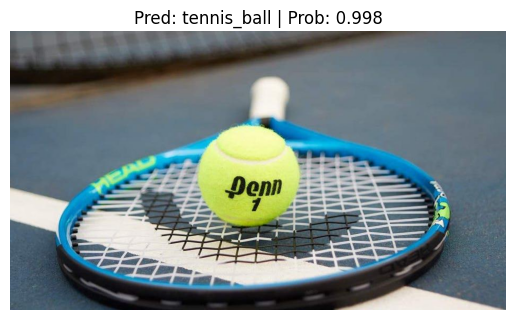

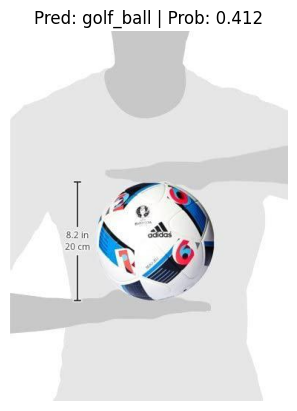

In [25]:
# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=m1,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

#Export

In [26]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 70.5 MB/s eta 0:00:00


In [27]:
!pip install onnxruntime-gpu onnx onnxconverter_common==1.8.1 pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.0 MB/s eta 0:00:00


In [28]:
import numpy as np    # we're going to use numpy to process input and output data
import onnxruntime    # to inference ONNX models, we use the ONNX Runtime
import onnx
from onnx import numpy_helper
import urllib.request
import json
import time

# display images in notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

In [29]:
img, label = test_data[0]

In [30]:
img.shape

torch.Size([3, 224, 224])

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.MFD_HUGE_1GB = m1.to(device)

In [32]:
x = torch.randn(2, 3, 224, 224, requires_grad=True).to(device)

In [33]:
#x = torch.randn(2, 3, 224, 224, requires_grad=True)
torch_out = m1(x)

# Export the model
torch.onnx.export(m1,                                       # model being run
                  x,                                           # model input (or a tuple for multiple inputs)
                  "resnet26dsports.onnx",                            # where to save the model (can be a file or file-like object)
                  export_params=True,                          # store the trained parameter weights inside the model file
                  opset_version=10,                            # the ONNX version to export the model to
                  do_constant_folding=True,                    # whether to execute constant folding for optimization
                  input_names = ['input'],                     # the model's input names
                  output_names = ['output'],                   # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},  # variable length axes
                                'output': {0 : 'batch_size'}})

In [34]:
import onnx

onnx_model = onnx.load("resnet26dsports.onnx")
onnx.checker.check_model(onnx_model)

In [35]:
onnx_model = onnx.load("resnet26dsports.onnx")

In [36]:
onnx.checker.check_model(onnx_model)

In [37]:
traced_model=torch.jit.trace(m1, torch.rand(8,3,224,224).to(device))

In [38]:
traced_output=traced_model(torch.rand(8,3,224,224).to(device))
traced_output.shape

torch.Size([8, 15])

In [39]:
# Run the model on the backend
session = onnxruntime.InferenceSession('resnet26dsports.onnx', None)

# get the name of the first input of the model
input_name = session.get_inputs()[0].name

print('Input Name:', input_name)

Input Name: input


In [40]:
def load_labels(path):
    with open(path) as f:
        data = json.load(f)
    return np.asarray(data)

def preprocess(input_data):
    # convert the input data into the float32 input
    img_data = input_data.astype('float32')

    #normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(img_data.shape).astype('float32')
    for i in range(img_data.shape[0]):
        norm_img_data[i,:,:] = (img_data[i,:,:]/255 - mean_vec[i]) / stddev_vec[i]

    #add batch channel
    norm_img_data = norm_img_data.reshape(1, 3, 224, 224).astype('float32')
    return norm_img_data

def softmax(x):
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(result):
    return softmax(np.array(result)).tolist()

In [41]:
filename = '/content/test/basketball/basketball_129.jpg'
input_image = Image.open(filename)

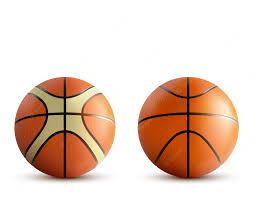

In [42]:
input_image

In [43]:
newsize = (224, 224)
input_image = input_image.resize(newsize)
# Shows the image in image viewer
input_image.show()

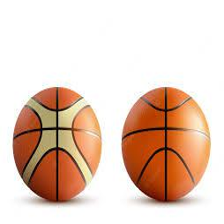

In [44]:
input_image

In [45]:
m1 = m1.to(device)
x = torch.randn(8, 3, 224, 224, requires_grad=True).to(device)

traced_model = torch.jit.trace(m1, x)

/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py:166: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if a.grad is not None:


Image size:  (224, 224)


(3, 224, 224)

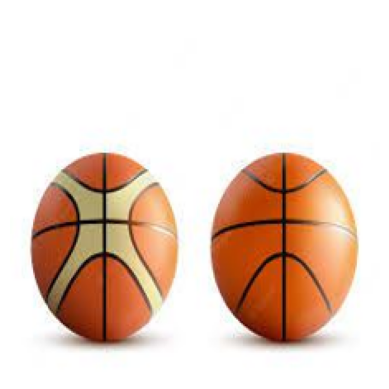

In [46]:
labels = class_names

print("Image size: ", input_image.size)
plt.axis('off')
display_image = plt.imshow(input_image)
image_data = np.array(input_image).transpose(2, 0, 1)
image_data.shape

In [47]:
input_data = preprocess(image_data)

In [48]:
input_data.shape

(1, 3, 224, 224)

In [49]:
start = time.time()
raw_result = session.run([], {input_name: input_data})
end = time.time()
res = postprocess(raw_result)

Final top prediction is: basketball
Inference time: 167.01 ms
============ Top 5 labels are: ============================
['basketball', 'football', 'golf_ball', 'american_football', 'tennis_ball']


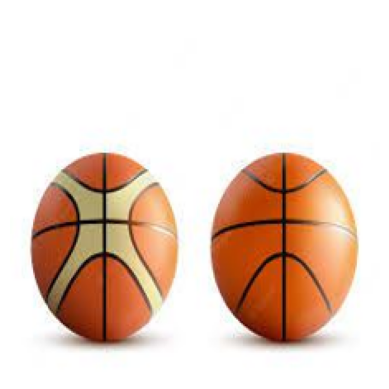

In [50]:
inference_time = np.round((end - start) * 1000, 2)
idx = np.argmax(res)

print('========================================')
print('Final top prediction is: ' + labels[idx])
print('========================================')

print('========================================')
print('Inference time: ' + str(inference_time) + " ms")
print('========================================')

sort_idx = np.flip(np.squeeze(np.argsort(res)))
print('============ Top 5 labels are: ============================')
print([labels[i] for i in sort_idx[:5].tolist()])
print('===========================================================')

plt.axis('off')
display_image = plt.imshow(input_image)

In [51]:
type(traced_model)

torch.jit._trace.TopLevelTracedModule

In [52]:
traced_model(torch.rand(8, 3, 224, 224).to(device)).shape

torch.Size([8, 15])

In [53]:
filename = '/content/test/basketball/basketball_129.jpg' # change to your filename
from torchvision import models, datasets, transforms as T
import torch
from PIL import Image
import numpy as np

input_image = Image.open(filename)
preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)
print("GPU Availability: ", torch.cuda.is_available())
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')

GPU Availability:  True


In [54]:
# Inference with ONNX Runtime
import onnxruntime
from onnx import numpy_helper
import time

session_fp32 = onnxruntime.InferenceSession("resnet26dsports.onnx", providers=['CPUExecutionProvider'])
# session_fp32 = onnxruntime.InferenceSession("resnet50.onnx", providers=['CUDAExecutionProvider'])
# session_fp32 = onnxruntime.InferenceSession("resnet50.onnx", providers=['OpenVINOExecutionProvider'])

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def run_sample(session, categories, inputs):
    latency = []
    start = time.time()
    input_arr = inputs.cpu().detach().numpy()
    ort_outputs = session.run([], {'input':input_arr})[0]
    latency.append(time.time() - start)
    output = ort_outputs.flatten()
    output = softmax(output) # this is optional
    top5_catid = np.argsort(-output)[:5]
    for catid in top5_catid:
        print(categories[catid], output[catid])
    return ort_outputs, latency

ort_output, latency = run_sample(session_fp32, class_names, input_batch)
print("ONNX Runtime CPU/GPU/OpenVINO Inference time = {} ms".format(format(sum(latency) * 1000 / len(latency), '.2f')))

basketball 0.9998728
football 4.6146844e-05
golf_ball 2.83028e-05
tennis_ball 2.4502677e-05
american_football 1.6214073e-05
ONNX Runtime CPU/GPU/OpenVINO Inference time = 112.12 ms


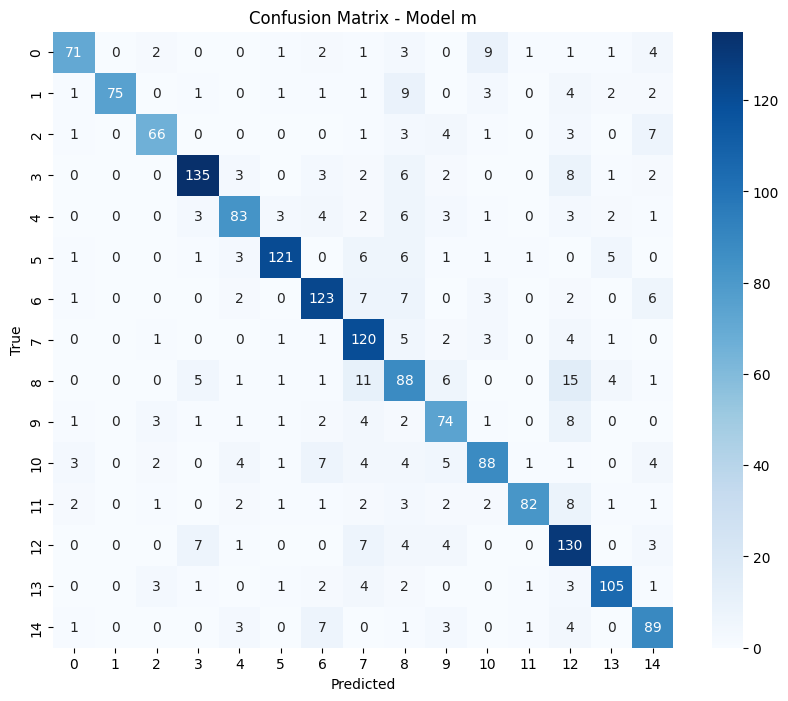

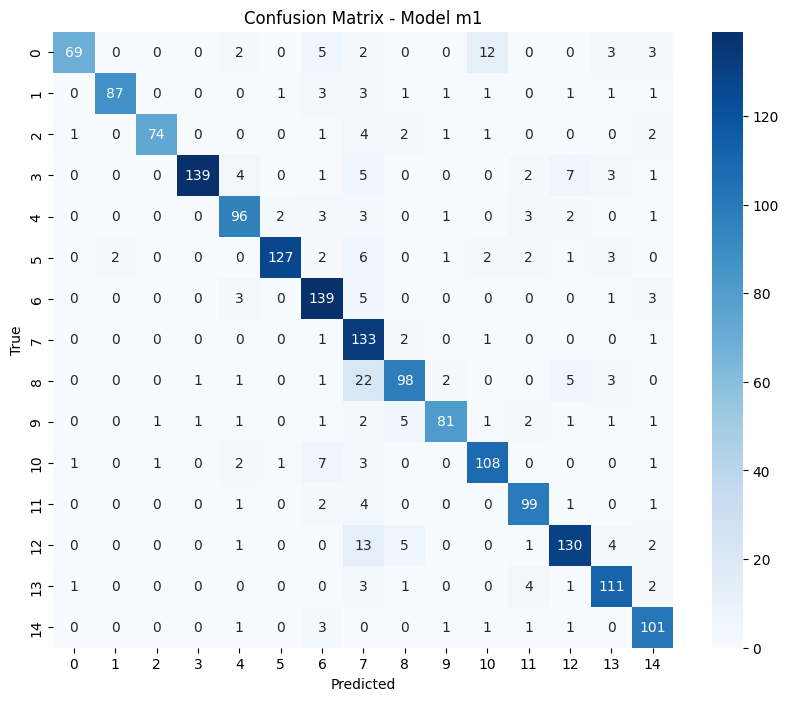

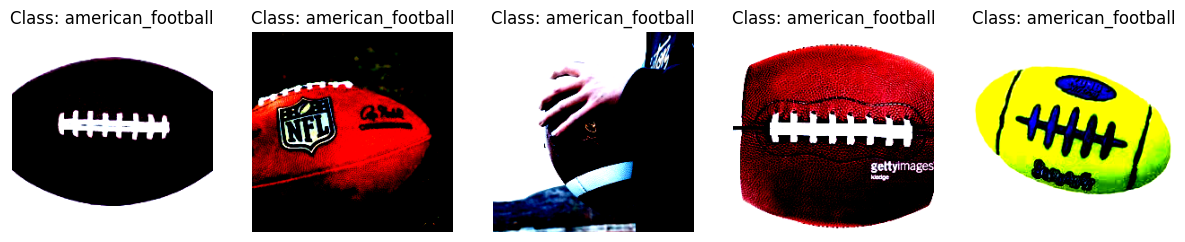

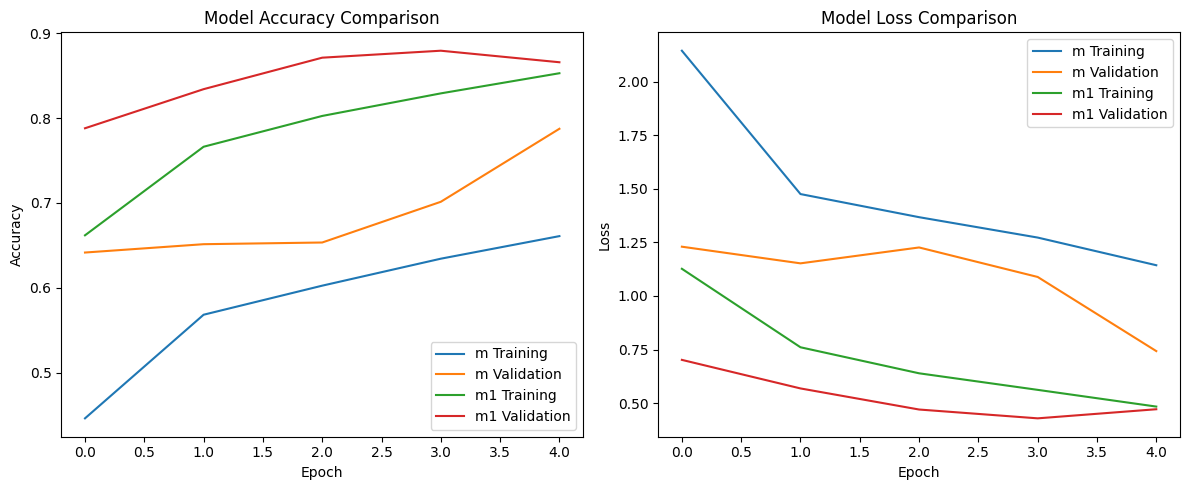

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# Confusion Matrix Function
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function to get predictions
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions for both models
y_pred_m, y_true = get_predictions(m, test_dataloader, device)
y_pred_m1, _ = get_predictions(m1, test_dataloader, device)

# Plot confusion matrices
plot_confusion_matrix(y_true, y_pred_m, 'Model m')
plot_confusion_matrix(y_true, y_pred_m1, 'Model m1')

# Sample Dataset Images
def plot_sample_images(dataloader, class_names, num_samples=5):
    # Get a batch of images
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Change from CWH to WHC format
        plt.title(f'Class: {class_names[labels[i]]}')
        plt.axis('off')
    plt.show()

# Plot sample images from the test set
plot_sample_images(test_dataloader, class_names)

# Comparison Graphs
def plot_model_comparison(results, results2):
    plt.figure(figsize=(12, 5))

    # Accuracy comparison
    plt.subplot(1, 2, 1)
    plt.plot(results['train_acc'], label='m Training')
    plt.plot(results['test_acc'], label='m Validation')
    plt.plot(results2['train_acc'], label='m1 Training')
    plt.plot(results2['test_acc'], label='m1 Validation')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss comparison
    plt.subplot(1, 2, 2)
    plt.plot(results['train_loss'], label='m Training')
    plt.plot(results['test_loss'], label='m Validation')
    plt.plot(results2['train_loss'], label='m1 Training')
    plt.plot(results2['test_loss'], label='m1 Validation')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the comparison graphs
plot_model_comparison(results, results2)